In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import cv2
from scipy.io.wavfile import write
from datetime import datetime
import subprocess
import numexpr as ne

# Simulation

In [2]:
def get_interpolated(array, index):
    if not hasattr(index, "__len__") or len(index) < 1: return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [3]:
def interpolate_1d(array, indices):
    t = indices.reshape(-1, 1, 1) % 1
    left = array[np.floor(indices).astype(np.int64)]
    right = array[np.ceil(indices).astype(np.int64)]
    print("first step done")
    return (1 - t) * left + t * right

In [4]:
interpolate_1d(np.array([[1, 2],[3, 4]]), np.array([0.5]))

first step done


array([[[2., 3.]]])

In [5]:
def gaussian(x, y, n, offset, width):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return np.exp(-(x*x + y*y) / (width*width)) + 0j

In [6]:
def parabolar(x, y, n, offset, factor):
    x = (x - n/2.0) / (n/2.0) - offset[0]
    y = (y - n/2.0) / (n/2.0) - offset[1]
    return factor * (x*x + y*y)


In [7]:
def calculate_next_psi(psi, dt, potential):
    n = psi.shape[0]
    next_psi = np.zeros((n, n), dtype=np.complex_)

    # potential-part
    next_psi = psi * np.exp(1j * dt * potential)

    next_psi = np.fft.fft2(next_psi)
    
    indices = 2 * np.pi * np.min([np.arange(n), n-np.arange(n)], axis=0)
    k = indices.reshape(-1, 1)
    l = indices.reshape(1, -1)
    theta = (k*k + l*l) * dt
    next_psi *= np.exp(1j * theta)

    next_psi = np.fft.ifft2(next_psi)
    return next_psi

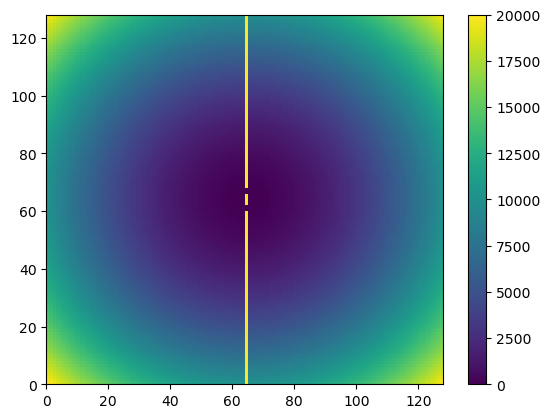

Finished simulation


In [8]:
n = 128
fps = 400
skip_frames = 20
duration = 5
simulation_speed = 0.005

slits_distance = 4
slits_width = 2
wall_height = 1e60

frames = [] # for storing the generated images

psi = np.array([[gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[parabolar(x, y, n, offset=[0,0], factor=10000) for x in range(n)] for y in range(n)])
potential[:64-slits_distance//2-slits_width, 64] = wall_height
potential[64+slits_distance//2+slits_width:, 64] = wall_height
potential[64-slits_distance//2:64+slits_distance//2, 64] = wall_height
frames.append(psi)

#plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(potential, vmin=0, vmax=20000)
plt.colorbar()
plt.show()


for i in range(fps*duration):
    psi = calculate_next_psi(psi, simulation_speed / fps, potential)
    frames.append(psi)

print("Finished simulation")

# Video

In [9]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_filename = f'simulation_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'
video = cv2.VideoWriter(video_filename, fourcc, fps/skip_frames, (800, 600))
for i, frame in enumerate(frames[::skip_frames]):
    plt.figure(figsize=(8, 6))
    plot = plt.pcolormesh(pow(np.abs(frame), 2.0/3.0), cmap='inferno', vmin=0, vmax=1, animated=True)
    plt.colorbar()
    plt.title('psi')

    # Save to temporary file
    plt.savefig('temp_frame.png')
    plt.close()

    # Read the image and add to the video
    img = cv2.imread('temp_frame.png')
    video.write(img)

print(f"Video saved as {video_filename}")
video.release()

Video saved as simulation_2024_04_10-13_12_47.mp4


# Sonification

In [11]:
average_parallel_listening = lambda array: np.average(array[:, :, 0])
average_orthogonal_listening = lambda array: np.average(array[:, :, 1])
average_norm_listening = lambda array: np.average(np.linalg.norm(array, axis=2))

point_parallel_listening = lambda array: array[20, 60, 0]
point_orthogonal_listening = lambda array: array[20, 60, 1]

In [12]:
sample_rate = 44100
sonification_duration = 2
sonification_duration = np.min([duration, sonification_duration])

listening = average_orthogonal_listening

dampening_per_second = 1 - 1e-12
spring_amount = sample_rate
min_mass = 0.00125
max_mass = 3.2


dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)

In [27]:
num_simulated_steps = sonification_duration * sample_rate

springs = np.indices((n, n)).transpose((1, 2, 0))[:, :, np.newaxis, :] + [[[[-1, 0], [1, 0], [0, -1], [0, 1]]]] # indices for each connected mass point for each mass point shape: (x, y, num_springs, indices_of_other_point
original_positions = np.indices((n, n), dtype=np.float64).transpose((1, 2, 0))

masses = min_mass + (max_mass - min_mass) * np.abs(frames)
angles = np.angle(frames)
springs_length = 1 - np.cos(angles[:, springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1], np.newaxis] - angles[:, 1:-1, 1:-1, np.newaxis, np.newaxis])

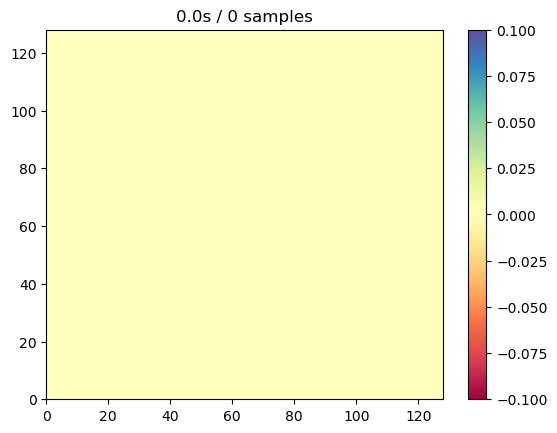

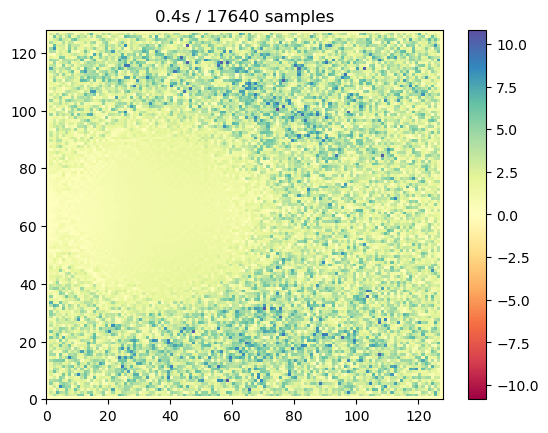

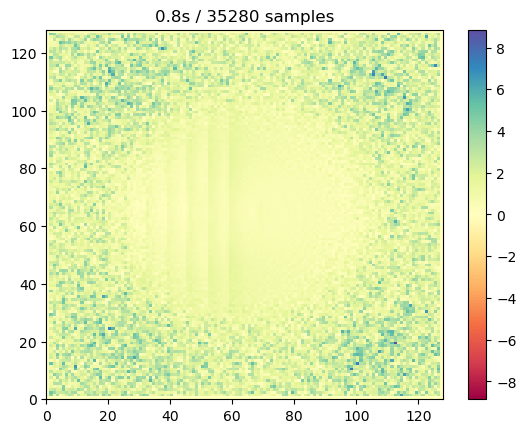

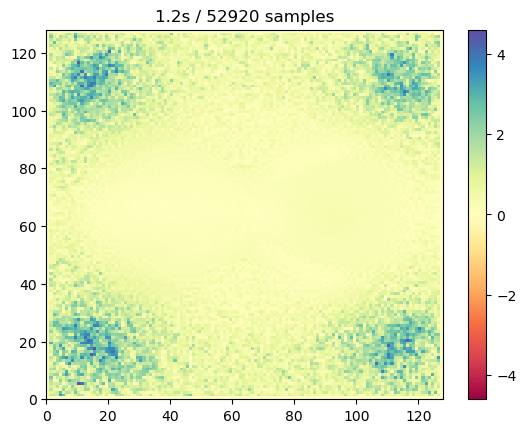

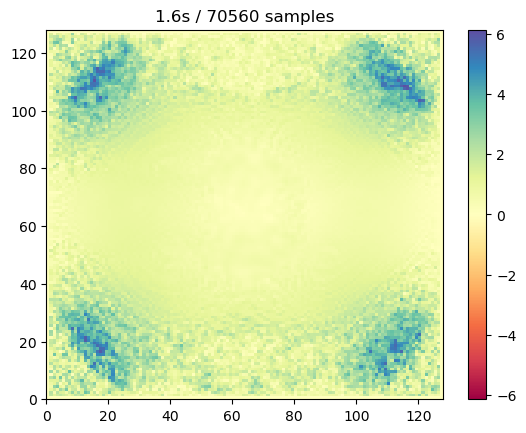

In [28]:
positions = np.copy(original_positions)
speeds = np.zeros((n, n, 2), dtype=np.float64)
forces = np.zeros((n, n, 2), dtype=np.float64)

audio = np.empty(num_simulated_steps)

data = frames[0]

for sample in range(num_simulated_steps):
    #print(sample)
    
    simulation_index = int(sample / sample_rate * fps)
    last_data = data
    data = frames[simulation_index] # no interpolation    

    offsets = positions[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - positions[1:-1, 1:-1, np.newaxis, :]
    distances = np.linalg.norm(offsets, axis=3)[:, :, :, np.newaxis]

    forces[1:-1, 1:-1] = np.sum(spring_amount * offsets * (distances - springs_length[simulation_index]) / distances, axis=2) # apply springs force
    
    # Add noise
    forces[1:-1, 1:-1, 0] += np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((n-2, n-2)) - 1)

    # Update speeds with forces, apply dampening
    speeds += forces / masses[simulation_index, :, :, np.newaxis] / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses[simulation_index, :, :, np.newaxis]
    
    positions += speeds / sample_rate

    audio[sample] = listening(positions - original_positions)

    #'''
    if sample % (sample_rate * sonification_duration // 5) == 0:
        plot_data = np.abs(np.linalg.norm(positions - original_positions, axis=2))
        scale = np.max(plot_data)
        plt.pcolormesh(plot_data, vmin=-scale, vmax=scale, cmap='Spectral')
        plt.colorbar()
        plt.title(f"{round(sample/sample_rate, 2) }s / {sample} samples")
        plt.show()
    #'''

In [29]:
audio[:1000]  *= np.square(np.linspace(start=0, stop=1, num=1000, endpoint=False))
audio[-1000:] *= np.square(np.linspace(start=1, stop=0, num=1000, endpoint=False))
audio_filename = f'sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as sonification_2024_04_10-13_42_57.wav


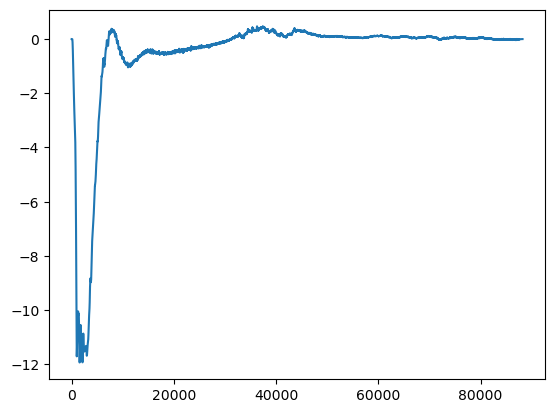

In [30]:
plt.plot(audio)

# Combine Audio & Video

In [31]:
combined_filename = f'combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    './ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 6.1.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--stat

CompletedProcess(args=['./ffmpeg', '-i', 'simulation_2024_04_10-13_12_47.mp4', '-i', 'sonification_2024_04_10-13_42_57.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'combination_2024_04_10-13_42_58.mp4'], returncode=0)